<a href="https://colab.research.google.com/github/afujii/class/blob/main/FluedDynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/computational-fluid-dynamics-using-python-modeling-laminar-flow-272dad1ebec

In [ ]:
import numpy as np
import os

In [ ]:
class Boundary:
    def __init__(self,boundary_type,boundary_value):
        self.DefineBoundary(boundary_type,boundary_value)
        
    def DefineBoundary(self,boundary_type,boundary_value):
        self.type=boundary_type
        self.value=boundary_value

In [ ]:
class Space:
    def __init__(self):
        pass
    
    def CreateMesh(self,rowpts,colpts):
        #Domain gridpoints
        self.rowpts=rowpts
        self.colpts=colpts
        #Velocity matrices
        self.u=np.zeros((self.rowpts+2,self.colpts+2))
        self.v=np.zeros((self.rowpts+2,self.colpts+2))
        self.u_star=np.zeros((self.rowpts+2,self.colpts+2))
        self.v_star=np.zeros((self.rowpts+2,self.colpts+2))
        self.u_next=np.zeros((self.rowpts+2,self.colpts+2))
        self.v_next=np.zeros((self.rowpts+2,self.colpts+2))
        self.u_c=np.zeros((self.rowpts,self.colpts))
        self.v_c=np.zeros((self.rowpts,self.colpts))
        #Pressure matrices
        self.p=np.zeros((self.rowpts+2,self.colpts+2))
        self.p_c=np.zeros((self.rowpts,self.colpts))

        #Set default source term
        self.SetSourceTerm()        
        
    def SetDeltas(self,breadth,length):
        self.dx=length/(self.colpts-1)
        self.dy=breadth/(self.rowpts-1)
    def SetInitialU(self,U):
        self.u=U*self.u
        
    def SetInitialV(self,V):
        self.v=V*self.v
        
    def SetInitialP(self,P):
        self.p=P*self.p
    def SetSourceTerm(self,S_x=0,S_y=0):
        self.S_x=S_x
        self.S_y=S_y

In [ ]:
class Fluid:
    def __init__(self,rho,mu):
        self.SetFluidProperties(rho,mu)
    
    def SetFluidProperties(self,rho,mu):
        self.rho=rho
        self.mu=mu

In [ ]:
#Note: The arguments to the function are all objects of our defined classes
#Set boundary conditions for horizontal velocity
def SetUBoundary(space,left,right,top,bottom):
    if(left.type=="D"):
        space.u[:,0]=left.value
    elif(left.type=="N"):
        space.u[:,0]=-left.value*space.dx+space.u[:,1]
    
    if(right.type=="D"):
        space.u[:,-1]=right.value
    elif(right.type=="N"):
        space.u[:,-1]=right.value*space.dx+space.u[:,-2]
        
    if(top.type=="D"):
        space.u[-1,:]=2*top.value-space.u[-2,:]
    elif(top.type=="N"):
        space.u[-1,:]=-top.value*space.dy+space.u[-2,:]
     
    if(bottom.type=="D"):
        space.u[0,:]=2*bottom.value-space.u[1,:]
    elif(bottom.type=="N"):
        space.u[0,:]=bottom.value*space.dy+space.u[1,:]

#Set boundary conditions for vertical velocity
def SetVBoundary(space,left,right,top,bottom):
    if(left.type=="D"):
        space.v[:,0]=2*left.value-space.v[:,1]
    elif(left.type=="N"):
        space.v[:,0]=-left.value*space.dx+space.v[:,1]
    
    if(right.type=="D"):
        space.v[:,-1]=2*right.value-space.v[:,-2]
    elif(right.type=="N"):
        space.v[:,-1]=right.value*space.dx+space.v[:,-2]
        
    if(top.type=="D"):
        space.v[-1,:]=top.value
    elif(top.type=="N"):
        space.v[-1,:]=-top.value*space.dy+space.v[-2,:]
     
    if(bottom.type=="D"):
        space.v[0,:]=bottom.value
    elif(bottom.type=="N"):
        space.v[0,:]=bottom.value*space.dy+space.v[1,:]
#Set boundary conditions for pressure
def SetPBoundary(space,left,right,top,bottom):
    if(left.type=="D"):
        space.p[:,0]=left.value
    elif(left.type=="N"):
        space.p[:,0]=-left.value*space.dx+space.p[:,1]
    
    if(right.type=="D"):
        space.p[1,-1]=right.value
    elif(right.type=="N"):
        space.p[:,-1]=right.value*space.dx+space.p[:,-2]
        
    if(top.type=="D"):
        space.p[-1,:]=top.value
    elif(top.type=="N"):
        space.p[-1,:]=-top.value*space.dy+space.p[-2,:]
     
    if(bottom.type=="D"):
        space.p[0,:]=bottom.value
    elif(bottom.type=="N"):
        space.p[0,:]=bottom.value*space.dy+space.p[1,:]

In [ ]:
def SetTimeStep(CFL,space,fluid):
    with np.errstate(divide='ignore'):
        dt=CFL/np.sum([np.amax(space.u)/space.dx,\
                           np.amax(space.v)/space.dy])
    #Escape condition if dt is infinity due to zero velocity initially
    if np.isinf(dt):
        dt=CFL*(space.dx+space.dy)
    space.dt=dt

In [ ]:
#The first function is used to get starred velocities from u and v at timestep t
def GetStarredVelocities(space,fluid):
    #Save object attributes as local variable with explicity typing for improved readability
    rows=int(space.rowpts)
    cols=int(space.colpts)
    u=space.u.astype(float,copy=False)
    v=space.v.astype(float,copy=False)
    dx=float(space.dx)
    dy=float(space.dy)
    dt=float(space.dt)
    S_x=float(space.S_x)
    S_y=float(space.S_y)
    rho=float(fluid.rho)
    mu=float(fluid.mu)
    
    #Copy u and v to new variables u_star and v_star
    u_star=u.copy()
    v_star=v.copy()
    
    #Calculate derivatives of u and v using the finite difference scheme. 
    #Numpy vectorization saves us from using slower for loops to go over each element in the u and v matrices
    u1_y=(u[2:,1:cols+1]-u[0:rows,1:cols+1])/(2*dy)
    u1_x=(u[1:rows+1,2:]-u[1:rows+1,0:cols])/(2*dx)
    u2_y=(u[2:,1:cols+1]-2*u[1:rows+1,1:cols+1]+u[0:rows,1:cols+1])/(dy**2)
    u2_x=(u[1:rows+1,2:]-2*u[1:rows+1,1:cols+1]+u[1:rows+1,0:cols])/(dx**2)
    v_face=(v[1:rows+1,1:cols+1]+v[1:rows+1,0:cols]+v[2:,1:cols+1]+v[2:,0:cols])/4
    u_star[1:rows+1,1:cols+1]=u[1:rows+1,1:cols+1]-dt*(u[1:rows+1,1:cols+1]*u1_x+v_face*u1_y)+(dt*(mu/rho)*(u2_x+u2_y))+(dt*S_x)   

    v1_y=(v[2:,1:cols+1]-v[0:rows,1:cols+1])/(2*dy)
    v1_x=(v[1:rows+1,2:]-v[1:rows+1,0:cols])/(2*dx)
    v2_y=(v[2:,1:cols+1]-2*v[1:rows+1,1:cols+1]+v[0:rows,1:cols+1])/(dy**2)
    v2_x=(v[1:rows+1,2:]-2*v[1:rows+1,1:cols+1]+v[1:rows+1,0:cols])/(dx**2)
    u_face=(u[1:rows+1,1:cols+1]+u[1:rows+1,2:]+u[0:rows,1:cols+1]+u[0:rows,2:])/4
    v_star[1:rows+1,1:cols+1]=v[1:rows+1,1:cols+1]-dt*(u_face*v1_x+v[1:rows+1,1:cols+1]*v1_y)+(dt*(mu/rho)*(v2_x+v2_y))+(dt*S_y)
    
    #Save the calculated starred velocities to the space object 
    space.u_star=u_star.copy()
    space.v_star=v_star.copy()    
    
    
#The second function is used to iteratively solve the pressure Possion equation from the starred velocities 
#to calculate pressure at t+delta_t
def SolvePressurePoisson(space,fluid,left,right,top,bottom):
    #Save object attributes as local variable with explicity typing for improved readability
    rows=int(space.rowpts)
    cols=int(space.colpts)
    u_star=space.u_star.astype(float,copy=False)
    v_star=space.v_star.astype(float,copy=False)
    p=space.p.astype(float,copy=False)
    dx=float(space.dx)
    dy=float(space.dy)
    dt=float(space.dt)
    rho=float(fluid.rho)
    factor=1/(2/dx**2+2/dy**2)
    
    #Define initial error and tolerance for convergence (error > tol necessary initially)
    error=1
    tol=1e-3

    #Evaluate derivative of starred velocities
    ustar1_x=(u_star[1:rows+1,2:]-u_star[1:rows+1,0:cols])/(2*dx)
    vstar1_y=(v_star[2:,1:cols+1]-v_star[0:rows,1:cols+1])/(2*dy)

    #Continue iterative solution until error becomes smaller than tolerance
    i=0
    while(error>tol):
        i+=1
        
        #Save current pressure as p_old
        p_old=p.astype(float,copy=True)
        
        #Evaluate second derivative of pressure from p_old
        p2_xy=(p_old[2:,1:cols+1]+p_old[0:rows,1:cols+1])/dy**2+(p_old[1:rows+1,2:]+p_old[1:rows+1,0:cols])/dx**2
        
        #Calculate new pressure 
        p[1:rows+1,1:cols+1]=(p2_xy)*factor-(rho*factor/dt)*(ustar1_x+vstar1_y)
        
        #Find maximum error between old and new pressure matrices
        error=np.amax(abs(p-p_old))
        
        #Apply pressure boundary conditions
        SetPBoundary(space,left,right,top,bottom)
        
        #Escape condition in case solution does not converge after 500 iterations
        if(i>500):
            tol*=10
            
    
#The third function is used to calculate the velocities at timestep t+delta_t using the pressure at t+delta_t and starred velocities
def SolveMomentumEquation(space,fluid):
    #Save object attributes as local variable with explicity typing for improved readability
    rows=int(space.rowpts)
    cols=int(space.colpts)
    u_star=space.u_star.astype(float,copy=False)
    v_star=space.v_star.astype(float,copy=False)
    p=space.p.astype(float,copy=False)
    dx=float(space.dx)
    dy=float(space.dy)
    dt=float(space.dt)
    rho=float(fluid.rho)
    u=space.u.astype(float,copy=False)
    v=space.v.astype(float,copy=False)

    #Evaluate first derivative of pressure in x direction
    p1_x=(p[1:rows+1,2:]-p[1:rows+1,0:cols])/(2*dx)
    #Calculate u at next timestep
    u[1:rows+1,1:cols+1]=u_star[1:rows+1,1:cols+1]-(dt/rho)*p1_x

    #Evaluate first derivative of pressure in y direction
    p1_y=(p[2:,1:cols+1]-p[0:rows,1:cols+1])/(2*dy)
    #Calculate v at next timestep
    v[1:rows+1,1:cols+1]=v_star[1:rows+1,1:cols+1]-(dt/rho)*p1_y

In [ ]:
def SetCentrePUV(space):
    space.p_c=space.p[1:-1,1:-1]
    space.u_c=space.u[1:-1,1:-1]
    space.v_c=space.v[1:-1,1:-1]

In [ ]:
def MakeResultDirectory(wipe=False):
    #Get path to the Result directory
    cwdir=os.getcwd()
    dir_path=os.path.join(cwdir,"Result")
    #If directory does not exist, make it
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path,exist_ok=True)
    else:
        #If wipe is True, remove files present in the directory
        if wipe:
            os.chdir(dir_path)
            filelist=os.listdir()
            for file in filelist:
                os.remove(file)
    
    os.chdir(cwdir)
            
    
def WriteToFile(space,iteration,interval):
    if(iteration%interval==0):
        dir_path=os.path.join(os.getcwd(),"Result")
        filename="PUV{0}.txt".format(iteration)
        path=os.path.join(dir_path,filename)
        with open(path,"w") as f:
            for i in range(space.rowpts):
                for j in range(space.colpts):
                    f.write("{}\t{}\t{}\n".format(space.p_c[i,j],space.u_c[i,j],space.v_c[i,j]))

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from FlowPy import *

In [ ]:
#### SPATIAL AND TEMPORAL INPUTS
length=4 #Length of computational domain in the x-direction
breadth=4 #Breadth of computational domain in the y-direction
colpts=257 #Number of grid points in the x-direction #KEEP ODD
rowpts=257 #Number of grid points in the y-direction #KEEP ODD
#Create an object of the class Space called cavity
cavity=Space()
cavity.CreateMesh(rowpts,colpts)
cavity.SetDeltas(breadth,length)

In [ ]:
#### FLUID PROPERTIES
rho=1 #Density of fluid
mu=0.01 #Viscosity of fluid
#Create an object of the class Fluid called water
water=Fluid(rho,mu)

In [ ]:
#### BOUNDARY SPECIFICATIONS
u_in=1 #Lid velocity
v_wall=0 #Velocity of fluid at the walls
p_out=0 #Gauge pressure at the boundaries
#Create objects of the class Boundary having either Dirichlet ("D") or Neumann ("N") type boundaries
flow=Boundary("D",u_in)
noslip=Boundary("D",v_wall)
zeroflux=Boundary("N",0)
pressureatm=Boundary("D",p_out)

In [ ]:
#### SIMULATION PARAMETERS
time=150 #Simulation time
CFL_number=0.8 #Reduce this if solution diverges
file_flag=1 #Keep 1 to print results to file
interval=100 #Record values in file per interval number of iterations

In [ ]:
#### RUN SIMULATION
# Print general simulation information
print("######## Beginning FlowPy Simulation ########")
print("#############################################")
print("# Simulation time: {0:.2f}".format(time))
print("# Mesh: {0} x {1}".format(colpts,rowpts))
print("# Re/u: {0:.2f}\tRe/v:{1:.2f}".format(rho*length/mu,rho*breadth/mu))
print("# Save outputs to text file: {0}".format(bool(file_flag)))
## Initialization
# Make directory to store results
MakeResultDirectory(wipe=True)
# Initialize counters
t=0
i=0
## Run
while(t<time):
    #Print time left
    sys.stdout.write("\rSimulation time left: {0:.2f}".format(time-t))
    sys.stdout.flush()
    #Set the time-step
    SetTimeStep(CFL_number,cavity,water)
    timestep=cavity.dt
    
    #Set boundary conditions
    SetUBoundary(cavity,noslip,noslip,flow,noslip)
    SetVBoundary(cavity,noslip,noslip,noslip,noslip)
    SetPBoundary(cavity,zeroflux,zeroflux,pressureatm,zeroflux)
    
    #Calculate starred velocities
    GetStarredVelocities(cavity,water)
    
    #Solve the pressure Poisson equation
    SolvePressurePoisson(cavity,water,zeroflux,zeroflux,\
pressureatm,zeroflux)
    #Solve the momentum equation
    SolveMomentumEquation(cavity,water)
    #Save variables and write to file
    SetCentrePUV(cavity)
    if(file_flag==1):
        WriteToFile(cavity,i,interval)
    #Advance time-step and counter
    t+=timestep
    i+=1

######## Beginning FlowPy Simulation ########
#############################################
# Simulation time: 150.00
# Mesh: 257 x 257
# Re/u: 400.00	Re/v:400.00
# Save outputs to text file: True
Simulation time left: 0.00

In [ ]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
#### Simulation inputs
rowpts=257
colpts=257
length=4
breadth=4

In [ ]:
#Go to the Result directory
cwdir=os.getcwd()
dir_path=os.path.join(cwdir,"Result")
os.chdir(dir_path)
#Go through files in the directory and store filenames
filenames=[]
iterations=[]
for root,dirs,files in os.walk(dir_path):
    for datafile in files:
        if "PUV" in datafile:
            filenames.append(datafile)
            no_ext_file=datafile.replace(".txt","").strip()
            iter_no=int(no_ext_file.split("V")[-1])
            iterations.append(iter_no)
#Discern the final iteration and interval
initial_iter=np.amin(iterations)            
final_iter=np.amax(iterations)
inter=(final_iter - initial_iter)/(len(iterations)-1)
number_of_frames=len(iterations)
sorted_iterations=np.sort(iterations)

In [ ]:
def read_datafile(iteration):
    #Set filename and path according to given iteration
    filename="PUV{0}.txt".format(iteration)
    filepath=os.path.join(dir_path,filename)
    #Load text file as numpy array
    arr=np.loadtxt(filepath,delimiter="\t")
    rows,cols=arr.shape
    #Define empty arrays for pressure and velocities
    p_p=np.zeros((rowpts,colpts))
    u_p=np.zeros((rowpts,colpts))
    v_p=np.zeros((rowpts,colpts))
    #Organize imported array into variables
    p_arr=arr[:,0]
    u_arr=arr[:,1]
    v_arr=arr[:,2]
    
    #Reshape 1D data into 2D
    p_p=p_arr.reshape((rowpts,colpts))
    u_p=u_arr.reshape((rowpts,colpts))
    v_p=v_arr.reshape((rowpts,colpts))
    
    return p_p,u_p,v_p

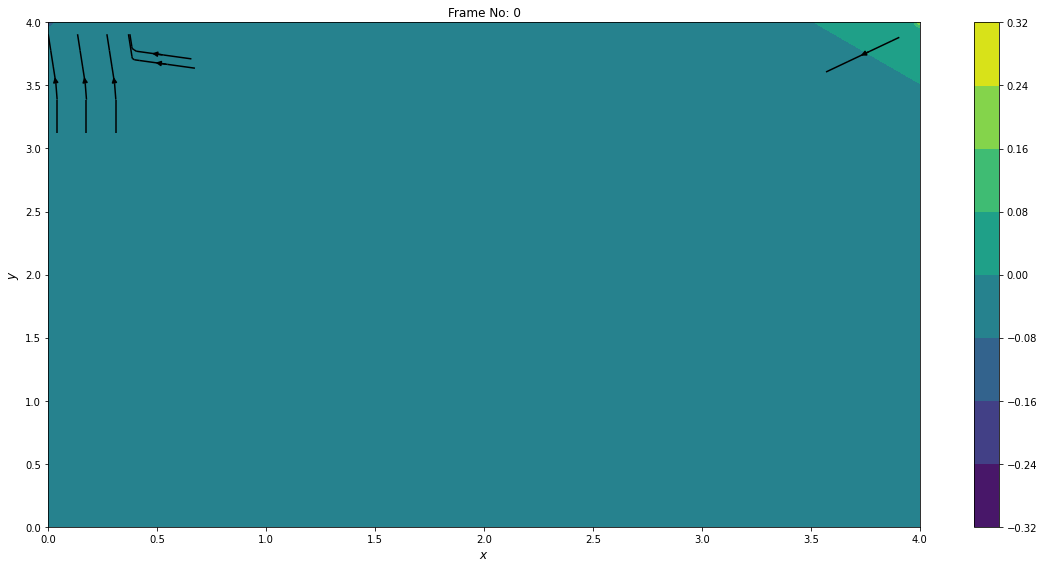

In [ ]:
#Create mesh for X and Y inputs to the figure
x=np.linspace(0,length,colpts)
y=np.linspace(0,breadth,rowpts)
[X,Y]=np.meshgrid(x,y)
#Determine indexing for stream plot (10 points only)
index_cut_x=int(colpts/10)
index_cut_y=int(rowpts/10)
#Create blank figure
fig=plt.figure(figsize=(16,8))
ax=plt.axes(xlim=(0,length),ylim=(0,breadth))
#Create initial contour and stream plot as well as color bar
p_p,u_p,v_p=read_datafile(0)
ax.set_xlim([0,length])
ax.set_ylim([0,breadth])
ax.set_xlabel("$x$",fontsize=12)
ax.set_ylabel("$y$",fontsize=12)
ax.set_title("Frame No: 0")
cont=ax.contourf(X,Y,p_p)
stream=ax.streamplot(X[::index_cut_y,::index_cut_x],Y[::index_cut_y,::index_cut_x],u_p[::index_cut_y,::index_cut_x],v_p[::index_cut_y,::index_cut_x],color="k")
fig.colorbar(cont)
fig.tight_layout()

In [ ]:
def animate(i):
    #Print frames left to be added to the animation
    sys.stdout.write("\rFrames remaining: {0:03d}".format(len(sorted_iterations)-i))
    sys.stdout.flush()
    #Get iterations in a sequential manner through sorted_iterations
    iteration=sorted_iterations[i]
    #Use the read_datafile function to get pressure and velocities
    p_p,u_p,v_p=read_datafile(iteration)
    #Clear previous plot and make contour and stream plots for current iteration
    ax.clear()
    ax.set_xlim([0,length])
    ax.set_ylim([0,breadth])
    ax.set_xlabel("$x$",fontsize=12)
    ax.set_ylabel("$y$",fontsize=12)
    ax.set_title("Frame No: {0}".format(i))
    cont=ax.contourf(X,Y,p_p)
    stream=ax.streamplot(X[::index_cut_y,::index_cut_x],\
                         Y[::index_cut_y,::index_cut_x],\
                         u_p[::index_cut_y,::index_cut_x],\
                         v_p[::index_cut_y,::index_cut_x],\
                         color="k")
    return cont,stream

In [ ]:
print("######## Making FlowPy Animation ########")
print("#########################################")
anim=animation.FuncAnimation(fig,animate,frames=number_of_frames,interval=50,blit=False)
movie_path=os.path.join(dir_path,"FluidFlowAnimation.mp4")
anim.save(r"{0}".format(movie_path))
print("\nAnimation saved as FluidFlowAnimation.mp4 in Result")

######## Making FlowPy Animation ########
#########################################
Frames remaining: 001
Animation saved as FluidFlowAnimation.mp4 in Result


In [ ]:
print(dir_path)

/content/Result
